In [2]:
import scipy.sparse as sp
import os
import numpy as np
from scipy.spatial import Delaunay
import pandas as pd 
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import power_transform,scale
import pandas as pd

In [3]:
cycif_eprs=pd.read_csv('/nfs/latdata/xinyi/cycif_data_for_gae/cycif_data.csv',header=0,index_col=0).to_numpy()
cycif_meta=pd.read_csv('/nfs/latdata/xinyi/cycif_data_for_gae/cycif_metadata.csv',header=0,index_col=0)

In [4]:
np.random.seed(3)

In [44]:
def preprocessX(data,savepath,lowThresh_per=None,highThresh_per=None,ifBinary=False,ifLog=False,standardize = True,ifGaussian=False):
    """
    param lowThresh_per: None or int - percentile below which expression are cutoff to 0
    param highThresh_per: None or int - percentile above which expression are assgined the value at highThresh_per
    """
    if lowThresh_per is not None:
        lowThresh=np.percentile(data,lowThresh_per,0)
        data[data<lowThresh]=0
    if highThresh_per is not None:
        highThresh=np.percentile(data,highThresh_per,0)
        for g in range(len(highThresh)):
            data[data[:,g]>highThresh[g],g]=highThresh[g]
    
    if ifBinary:
        lowThresh=np.percentile(data,lowThresh_per,0)
        data[data<lowThresh]=0
        data[data>=lowThresh]=1
    
    if ifLog:
        data=np.log(data+0.001)
    
    if ifGaussian:
        data=power_transform(data,standardize=standardize)
    elif standardize:
        data=scale(data,axis=0, with_mean=True, with_std=True, copy=True)
        
    data=sp.csr_matrix(data)
    sp.save_npz(savepath,data)

In [8]:
def getA_delaunay(sobj_coordMtx,xname,yname,savepath=None):
    a_size=sobj_coordMtx.shape[0]
    a=sp.lil_matrix((a_size,a_size))
    
    sobj_coord_np=sobj_coordMtx.loc[:,[xname,yname]].to_numpy()
    tri = Delaunay(sobj_coord_np)
    
    for tri_i in range(tri.simplices.shape[0]):
        tri_i_idx=tri.simplices[tri_i,:]
        a[tri_i_idx[0],tri_i_idx[1]]=1
        a[tri_i_idx[1],tri_i_idx[0]]=1
        a[tri_i_idx[0],tri_i_idx[2]]=1
        a[tri_i_idx[2],tri_i_idx[0]]=1
        a[tri_i_idx[1],tri_i_idx[2]]=1
        a[tri_i_idx[2],tri_i_idx[1]]=1
    
    a=a.tocsr()
    if savepath !=None:
        sp.save_npz(savepath,a)
    else:
        return a
    
def getA_knn(sobj_coordMtx,k,a_mode,xname,yname,savepath=None,ifpanda=True):
    if ifpanda:
        sobj_coord_np=sobj_coordMtx.loc[:,[xname,yname]].to_numpy()
    else:
        sobj_coord_np=np.copy(sobj_coordMtx)
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(sobj_coord_np)
    a=nbrs.kneighbors_graph(sobj_coord_np,mode=a_mode)
    if a_mode=='connectivity':
        a=a-sp.identity(sobj_coordMtx.shape[0],format='csr')
    if savepath !=None:
        sp.save_npz(savepath,a)
    else:
        return a

def randomA(sobj_coordMtx,xname,yname):
    sobj_coord_np=sobj_coordMtx.loc[:,[xname,yname]].to_numpy()
    randomCoord=np.random.uniform(size=sobj_coord_np.shape)
    return randomCoord

In [56]:
xsavepath=os.path.join('/nfs','latdata','xinyi','cycif_data_for_gae','xamatrices','x')
cycif_eprs_processed=np.copy(cycif_eprs)
preprocessX(cycif_eprs_processed,os.path.join(xsavepath,'standardize.npz'))
cycif_eprs_processed=np.copy(cycif_eprs)
preprocessX(cycif_eprs_processed,os.path.join(xsavepath,'binary.npz'),lowThresh_per=95,ifBinary=True)
cycif_eprs_processed=np.copy(cycif_eprs)
preprocessX(cycif_eprs_processed,os.path.join(xsavepath,'standardize_log.npz'),ifLog=True)
cycif_eprs_processed=np.copy(cycif_eprs)
preprocessX(cycif_eprs_processed,os.path.join(xsavepath,'standardize_log_gaussian.npz'),ifLog=True,ifGaussian=True)
cycif_eprs_processed=np.copy(cycif_eprs)
preprocessX(cycif_eprs_processed,os.path.join(xsavepath,'standardize_lowThresh.npz'),lowThresh_per=0.5)
cycif_eprs_processed=np.copy(cycif_eprs)
preprocessX(cycif_eprs_processed,os.path.join(xsavepath,'standardize_lowThresh_highThresh.npz'),lowThresh_per=0.5,highThresh_per=99.5)


In [58]:
asavepath=os.path.join('/nfs','latdata','xinyi','cycif_data_for_gae','xamatrices','a')
getA_delaunay(cycif_meta,'centroid_x','centroid_y',savepath=os.path.join(asavepath,'a_delaunay.npz'))
getA_knn(cycif_meta,5,'connectivity','centroid_x','centroid_y',os.path.join(asavepath,'knn5_connectivity.npz'))
getA_knn(cycif_meta,5,'distance','centroid_x','centroid_y',os.path.join(asavepath,'knn5_distance.npz'))
getA_knn(cycif_meta,10,'connectivity','centroid_x','centroid_y',os.path.join(asavepath,'knn10_connectivity.npz'))
getA_knn(cycif_meta,10,'distance','centroid_x','centroid_y',os.path.join(asavepath,'knn10_distance.npz'))
getA_knn(cycif_meta,20,'connectivity','centroid_x','centroid_y',os.path.join(asavepath,'knn20_connectivity.npz'))
getA_knn(cycif_meta,20,'distance','centroid_x','centroid_y',os.path.join(asavepath,'knn20_distance.npz'))

In [9]:
asavepath=os.path.join('/nfs','latdata','xinyi','cycif_data_for_gae','xamatrices','a')
random20=randomA(cycif_meta,'centroid_x','centroid_y')
getA_knn(random20,20,'connectivity','centroid_x','centroid_y',os.path.join(asavepath,'random20_connectivity.npz'),False)

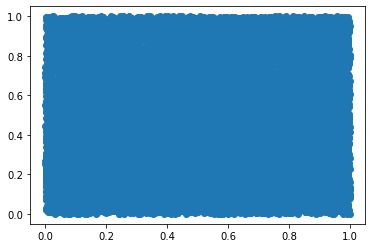

In [14]:
import matplotlib.pyplot as plt
plt.scatter(random20[:,0],random20[:,1])